The scripts are aimed at justifying the use of FGOC or dirFGOC scores. The main point is that the higher the score , higher is the chance that the gene pairs are within operons. 

A few reference organisms and their operons are selected. For example E.coli and B.subtilis
Database used: 
    (1) MicrobesOnline: http://meta.microbesonline.org/operons/ (downloaded on 27th Sept 2015).
        A number of organisms has to be individually downloaded.
        Organisms chosen - 
            (a) eco: Escherichia coli str. K-12 substr. MG1655
            (b) bsu: Bacillus subtilis subsp. subtilis 168
            

Histogram is plotted for the frequency of dirFGOC score between gene pairs in the organism. The histogram for gene pairs occuring within an operon and those between operon is compared.
A fractional odds ratio is calculate to better illustrate the fact that higher the dirFGOC score is more likely it is to be in an operon. 


In [6]:
import pickle
import os

def loadPkl(fname):
    pklDir = '/home/jaggu/research/projectFiles/operons/pklFiles'
    f = os.path.join(pklDir,fname)
    db = pickle.load(open(f))
    return db

locus_cog_dict = loadPkl('locus_cog.dict.pkl')
cogPair_fgocInfo_dict = loadPkl('cogPair_fgocInfo.dict.pkl')

print "Dictionaries loaded"

Dictionaries loaded


In [187]:
operondbDir = '/home/jaggu/research/downloads/operons_databases/microbesOnline'
org = 'eco' 
#org = 'bsu'
fname = org+'.'+'operon'
ifile = open(os.path.join(operondbDir,fname))
lines = ifile.readlines()
ifile.close()

# Dictionary
wOp_dict = dict() #Dictioanry of lTagPair:[dirFGOC,fgoc] for within Operon pairs
bwOp_dict = dict() #Dictionary of lTagPair:[dirFGOC,fgoc] for between Operon pairs

def getCog(lTag):
    try:
        cog = locus_cog_dict[lTag]
    except KeyError:
        cog = 'nan'
    if cog == '-': cog = 'nan' #Some wierd bug
    return cog

def getFgocInfo(lTag1,lTag2):
    cogA = getCog(lTag1)
    cogB = getCog(lTag2)
    if cogA is 'nan' or cogB is 'nan':
        return None
    else:
        try: fgocInfo = cogPair_fgocInfo_dict[(cogA,cogB)]
        except KeyError: fgocInfo = cogPair_fgocInfo_dict[(cogB,cogA)] #Opposite strand
    return fgocInfo

for line in lines[1:]:
    lTag1,lTag2,bOp = [line.split('\t')[i] for i in [2,3,6]]
    fgocInfo = getFgocInfo(lTag1,lTag2)
    if fgocInfo:
        dirFgoc,fgoc = fgocInfo[3],fgocInfo[4]
        if bOp == 'TRUE':
            wOp_dict[(lTag1,lTag2)]=[dirFgoc,fgoc]
        else:
            bwOp_dict[(lTag1,lTag2)]=[dirFgoc,fgoc]

print "Within and Between operon Dictionaries created for Org : %s"%(org)
print "Number of within operon gene pairs (mapped to COG)  : %d"%(len(wOp_dict))
print "Number of between operon gene pairs (mapped to COG) : %d"%(len(bwOp_dict))


Within and Between operon Dictionaries created for Org : eco
Number of within operon gene pairs (mapped to COG)  : 1422
Number of between operon gene pairs (mapped to COG) : 753


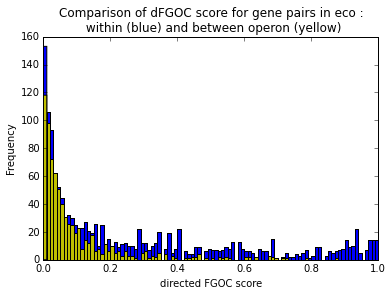

In [195]:
% matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

fig = plt.Figure()
ax = fig.add_subplot(1,1,1)

w_vals = [wOp_dict.values()[i][0] for i in range(0,len(wOp_dict))]
bw_vals = [bwOp_dict.values()[i][0] for i in range(0,len(bwOp_dict))]

n_w,bins_w,patches_w = plt.hist(w_vals,bins=np.arange(0,1.01,0.01))
n_bw,bins_bw,patches_bw = plt.hist(bw_vals,bins=np.arange(0,1.01,0.01),color='y')
plt.xlabel('directed FGOC score')
plt.ylabel('Frequency')
plt.title('Comparison of dFGOC score for gene pairs in %s : \n within (blue) and between operon (yellow)'%(org))
plt.show()

/home/jaggu/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:4: RuntimeWarning: invalid value encountered in true_divide


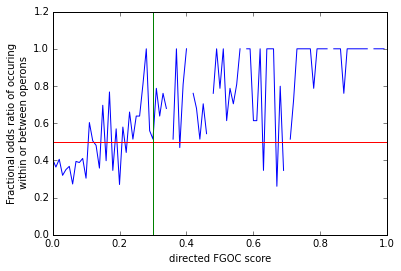

In [197]:
prob_w = n_w/len(wOp_dict)
prob_bw = n_bw/len(bwOp_dict)

yVal = prob_w/(prob_w + prob_bw) #Fraction Odds ratio -> prob(within operon)/(prob(within)+prob(between))

xVal = np.arange(0,1.,0.01)
plt.plot(xVal,yVal)
plt.axhline(y=0.5,color='r')
plt.axvline(x=0.3,color='g')
plt.ylim([0,1.2])
plt.xlabel('directed FGOC score')
plt.ylabel('Fractional odds ratio of occuring \n within or between operons')

plt.show()